# RandomForestClassifier

$ pip install graphviz

In [1]:
import math
import torch
import numpy as np
import gpytorch
import pandas as pd
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

from sklearn.preprocessing import StandardScaler
# importing random forest classifier from assemble module
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint


# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

import random
random.seed(2024)

In [2]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import itertools
# from sklearn 0.19.2 documentation:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar(shrink=0.7)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [3]:
# Load data file
uq_path = "/Users/radhi/Desktop/CAPSTONE_DATA/NEK_data_4Berkeley/NEK3" 
train_x_df = pd.read_csv(uq_path+"/NEK3_binding_random_fold1_trainX.csv")
train_y_df = pd.read_csv(uq_path+"/NEK3_binding_random_fold1_trainY.csv")
test_x_df = pd.read_csv(uq_path+"/NEK3_binding_random_fold1_testX.csv")
test_y_df = pd.read_csv(uq_path+"/NEK3_binding_random_fold1_testY.csv")
test_x_df

,ASA+_per_atom,ASA-,ASA_H_per_atom,ASA_P,ASA_per_atom,BCUT_PEOE_0,BCUT_PEOE_1,BCUT_PEOE_2,BCUT_PEOE_3,BCUT_SLOGP_0_per_atom,...,vsurf_Wp2_per_atom,vsurf_Wp3,vsurf_Wp4,vsurf_Wp5,vsurf_Wp6,vsurf_Wp7,vsurf_Wp8,weinerPath,weinerPol_per_atom,zagreb_per_atom
0,10.215013,142.21526,6.836120,244.47214,15.890644,-2.194154,-0.719023,0.731004,2.217017,-0.086358,...,21.333333,243.750,81.125,33.000,10.000,0.750,0.000,513,0.925926,3.407407
1,7.736764,220.71700,7.970176,205.31177,11.080960,-2.681831,-0.546122,0.637987,2.689039,-0.052606,...,9.878788,205.000,42.250,14.000,4.375,0.375,0.000,3825,0.878788,2.939394
2,8.211856,304.34698,8.814355,271.20950,13.745438,-2.403042,-0.574742,0.596937,2.408815,-0.042698,...,12.236364,216.750,48.000,19.125,5.750,0.250,0.000,4067,0.909091,3.200000
3,8.901980,195.95447,8.445429,222.74628,13.395346,-2.583713,-0.575453,0.617978,2.567737,-0.057201,...,12.941667,216.250,63.125,26.000,8.000,1.000,0.000,1508,0.933333,3.066667
4,7.612832,287.15073,9.292597,194.76367,12.833755,-2.537550,-0.628175,0.660120,2.707292,-0.049639,...,9.900000,152.500,44.750,19.875,7.750,1.000,0.375,3569,0.818182,3.018182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
277,10.206247,174.56108,11.438849,117.39546,13.786759,-2.647072,-0.620867,0.690330,2.605075,-0.055629,...,11.690000,112.750,19.250,8.375,2.625,0.125,0.000,2944,0.880000,3.200000
278,8.224840,221.81551,10.469413,138.76630,14.219854,-2.554365,-0.615955,0.599157,2.565347,-0.088887,...,13.371622,159.875,43.250,14.125,2.250,0.000,0.000,975,0.810811,2.918919
279,8.642949,161.90437,8.153549,186.68533,12.940353,-2.492239,-0.584590,0.657366,2.468000,-0.066054,...,11.259615,138.875,37.250,13.875,3.500,0.250,0.000,1301,0.846154,3.025641
280,7.236550,241.08192,7.003955,254.33978,11.466057,-2.665590,-0.491930,0.530384,2.600261,-0.048795,...,8.043860,118.500,19.125,7.250,2.250,0.000,0.000,4011,0.982456,3.333333


In [4]:
# Transform data to PyTorch tensors

# Scale data
x_df = pd.concat([train_x_df, test_x_df])

scaling=StandardScaler()
 
# Use fit and transform method 
scaling.fit(x_df)
Scaled_data=scaling.transform(x_df)
train_x = scaling.transform(train_x_df)
test_x = scaling.transform(test_x_df) 

train_y = train_y_df.to_numpy().flatten()
test_y = test_y_df.to_numpy().flatten()

print(train_x.shape)
print(train_y.shape)

(1122, 306)
(1122,)


In [5]:
# Construct a RF classification model

# creating a RF classifier
clf = RandomForestClassifier(n_estimators = 100)  
 
# Training the model on the training dataset
# fit function is used to train the model using the training sets as parameters
clf.fit(train_x, train_y)
 
# performing predictions on the test dataset
test_pred_y = clf.predict(test_x)




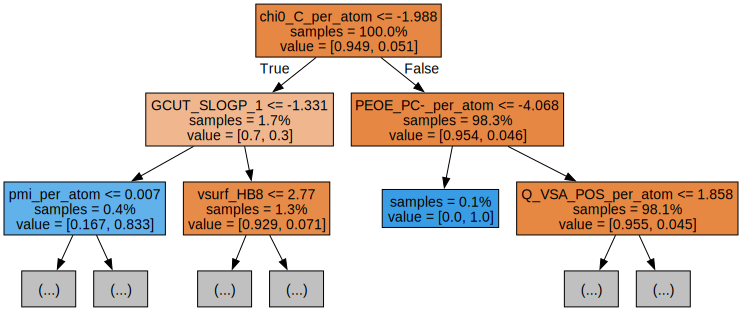

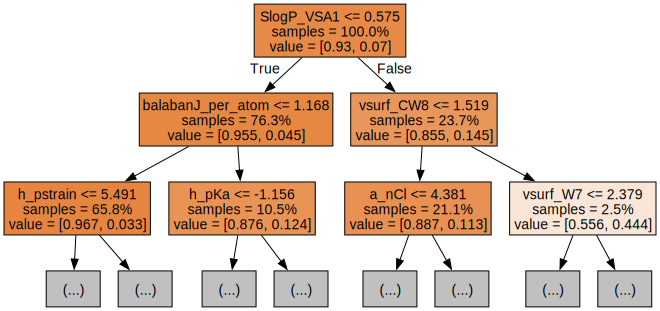

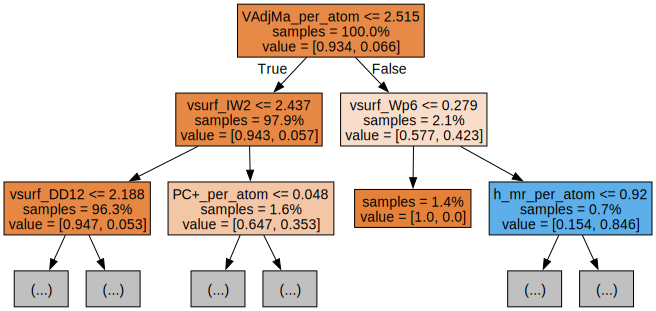

In [6]:
# Export the first three decision trees from the forest

for i in range(3):
    tree = clf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=train_x_df.columns,  
                               filled=True,  
                               max_depth=2, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

Confusion matrix, without normalization
[[264   1]
 [ 17   0]]


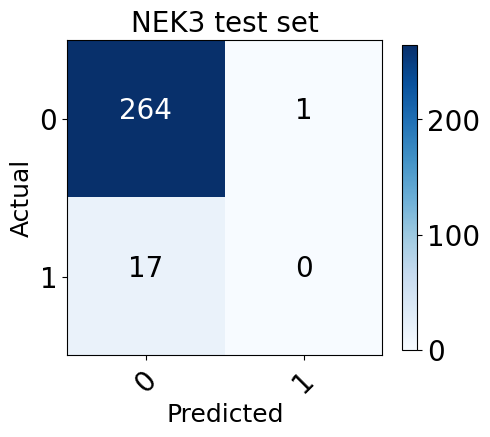

In [8]:
# Create the confusion matrix
test_cm = confusion_matrix(test_y, test_pred_y)

class_names = ["0","1"]
plt.rcParams.update({"font.size": 20})
label_font = {'size':'18'}  # Adjust to fit

ax = plt.figure(figsize=(5,5))
plt.title("NEK3 test set",fontsize=20)
plot_confusion_matrix(test_cm, classes=class_names, normalize=False)
plt.xlabel("Predicted",fontdict=label_font);
plt.ylabel("Actual",fontdict=label_font);


## Hyperparameter tuning

In [9]:
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,50)}

# Create a random forest classifier
rf = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(train_x, train_y)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1741203a0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x2b144d6d0>})

In [10]:
# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 33, 'n_estimators': 59}


Confusion matrix, without normalization
[[265   0]
 [ 17   0]]


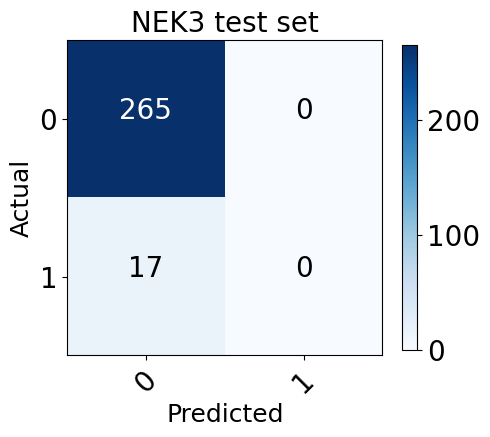

In [11]:
# Generate predictions with the best model
test_pred_y_best = best_rf.predict(test_x)

# Create the confusion matrix
test_best_cm = confusion_matrix(test_y, test_pred_y_best)
class_names = ["0","1"]
plt.rcParams.update({"font.size": 20})
label_font = {'size':'18'}  # Adjust to fit

ax = plt.figure(figsize=(5,5))
plt.title("NEK3 test set",fontsize=20)
plot_confusion_matrix(test_best_cm, classes=class_names, normalize=False)
plt.xlabel("Predicted",fontdict=label_font);
plt.ylabel("Actual",fontdict=label_font);
